In [2]:
#import libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from scipy.stats import pearsonr, linregress

In [4]:
# 1) Load data
file_path = r"C:\Users\Ganesh\Downloads\AH_Provisional_COVID-19_Deaths_by_Hospital_Referral_Region.csv"
df = pd.read_csv(file_path)

In [5]:
df.columns = df.columns.str.strip()
print("🔍 Columns:", df.columns.tolist())

🔍 Columns: ['Data as of', 'Start Date', 'End Date', 'MMWR Year', 'MMWR Week', 'Week Ending Date', 'HRR Name', 'HRR Number', 'State', 'Total Deaths', 'COVID-19 Deaths', 'Total Deaths over 65 years', 'COVID-19 Deaths over 65 years', 'Total Deaths 65 to 74 years', 'COVID-19 Deaths 65 to 74 years', 'Total Deaths 75 to 84 years', 'COVID-19 Deaths 75 to 84 years', 'Total Deaths over 85 years', 'COVID-19 Deaths over 85 years', 'Footnote', 'Accuracy_index']


In [6]:
# 2) Auto-detect key columns
def find_column(fragments):
    for frag in fragments:
        for col in df.columns:
            if frag.lower() in col.lower():
                return col
    return None

date_col   = find_column(["week ending", "end date", "start date"])
death_col  = find_column(["covid-19 deaths", "total deaths"])
region_col = find_column(["hrr name", "hrr", "region", "referral"])

In [7]:
if not date_col:   raise KeyError("Date column not detected—check printed list above.")
if not death_col:  raise KeyError("Death column not detected—check printed list above.")
if not region_col: raise KeyError("Region column not detected—check printed list above.")

print(f"✅ Using: Date='{date_col}', Deaths='{death_col}', Region='{region_col}'")

# 3) Data Cleaning & Preprocessing
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.dropna(subset=[date_col])
df[death_col] = pd.to_numeric(df[death_col], errors='coerce').fillna(0)
df['Year'] = df[date_col].dt.year
df['Month'] = df[date_col].dt.month
df['Week'] = df[date_col].dt.isocalendar().week

✅ Using: Date='Week Ending Date', Deaths='COVID-19 Deaths', Region='HRR Name'


In [8]:
# 4) Outlier detection (optional simple check)
death_summary = df[death_col].describe()
print("\n📊 Death Column Summary:")
print(death_summary)

# Remove very high outliers if needed (e.g., >99th percentile)
upper_limit = df[death_col].quantile(0.99)
df = df[df[death_col] <= upper_limit]


📊 Death Column Summary:
count    1756.000000
mean        0.835375
std         4.090059
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        45.162333
Name: COVID-19 Deaths, dtype: float64


In [9]:
# 5) Statistical Analysis
print("\n📈 Statistical Analysis:")
# a) Total deaths per region
region_stats = df.groupby(region_col)[death_col].sum().sort_values(ascending=False)
print(f"Top 5 regions by total deaths:\n{region_stats.head()}\n")

# b) Correlation: Deaths vs Month
monthly_avg = df.groupby('Month')[death_col].mean()
corr, _ = pearsonr(df['Month'], df[death_col])
print(f"Pearson correlation between Month and Deaths: {corr:.2f}")

# c) Linear regression: Year vs Total Deaths
yearly = df.groupby('Year')[death_col].sum().reset_index()
slope, intercept, r_value, p_value, std_err = linregress(yearly['Year'], yearly[death_col])
print(f"Linear trend: y = {slope:.2f}x + {intercept:.2f} (R² = {r_value**2:.2f})")



📈 Statistical Analysis:
Top 5 regions by total deaths:
HRR Name
AL- MONTGOMERY    179.620900
AL- MOBILE        169.992950
AL- TUSCALOOSA    143.196288
AL- HUNTSVILLE    138.003998
AL- BIRMINGHAM     96.621972
Name: COVID-19 Deaths, dtype: float64

Pearson correlation between Month and Deaths: 0.02
Linear trend: y = 29.11x + -58665.23 (R² = 0.20)


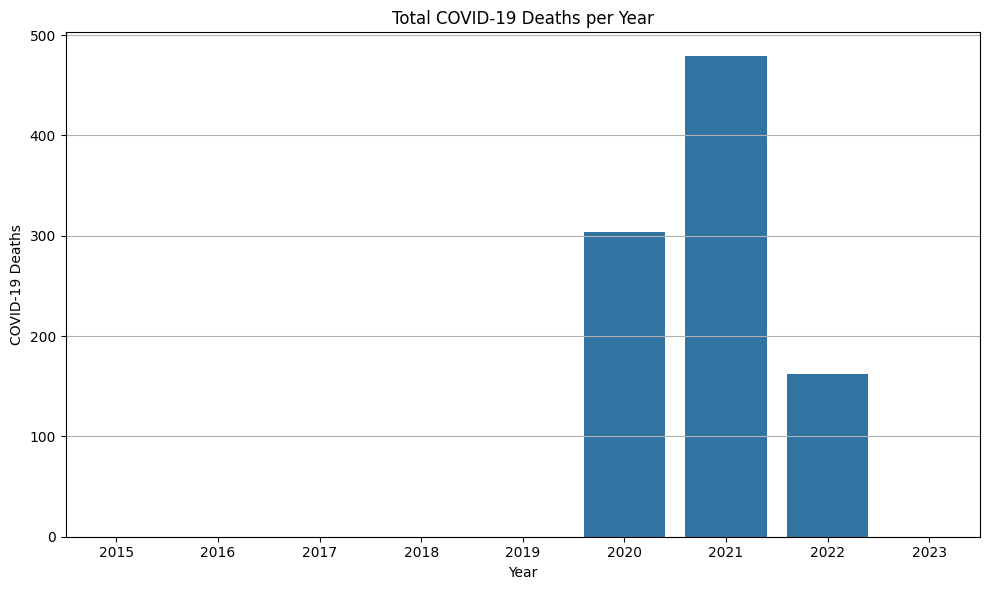

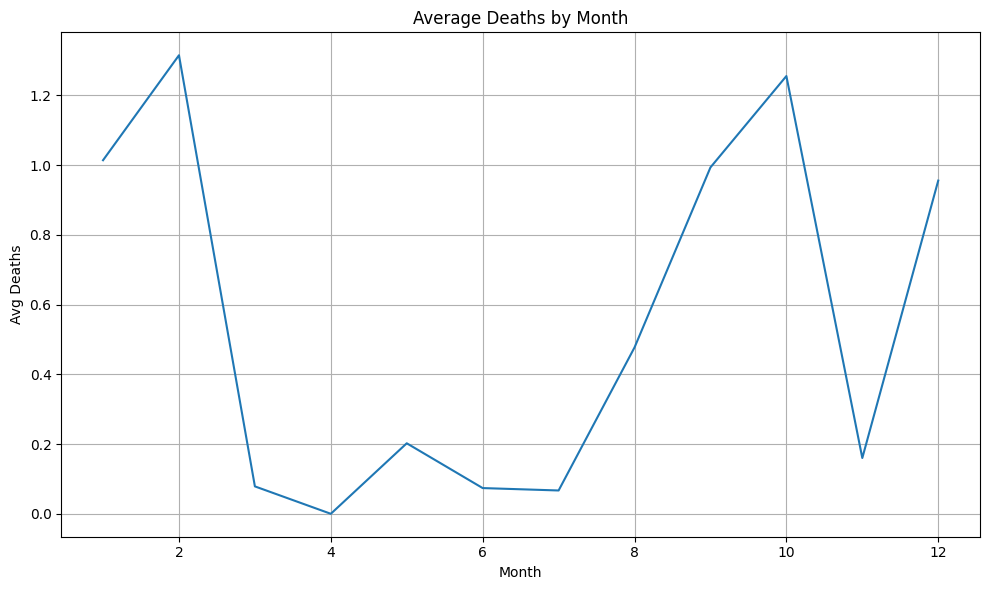

interactive(children=(Dropdown(description='Year:', options=(np.int32(2015), np.int32(2016), np.int32(2017), n…

<function __main__.plot_by_year(yr)>

In [10]:
# 6) Visualizations

# a) Total deaths per year
plt.figure(figsize=(10,6))
sns.barplot(x='Year', y=death_col, data=yearly)
plt.title('Total COVID-19 Deaths per Year')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# b) Correlation plot: Month vs Avg Deaths
plt.figure(figsize=(10,6))
sns.lineplot(x=monthly_avg.index, y=monthly_avg.values)
plt.title('Average Deaths by Month')
plt.xlabel('Month')
plt.ylabel('Avg Deaths')
plt.grid(True)
plt.tight_layout()
plt.show()

# 7) Interactive: Top 10 regions per year
def plot_by_year(yr):
    top10 = (df[df['Year']==yr]
             .groupby(region_col)[death_col]
             .sum()
             .sort_values(ascending=False)
             .head(10))
    plt.figure(figsize=(12,6))
    sns.barplot(x=top10.index, y=top10.values)
    plt.title(f'Top 10 {region_col}s in {yr}')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Deaths')
    plt.tight_layout()
    plt.show()

widgets.interact(
    plot_by_year,
    yr=widgets.Dropdown(
        options=sorted(df['Year'].unique()),
        description='Year:',
        style={'description_width': 'initial'}
    )
)